# Исследование надёжности заёмщиков

### 0.1 Содержание проекта
<a id='content'></a>

1. [Шаг 1. Открытие файла](#step_1)
2. [Шаг 2. Предобработка данных](#step_2)
3. [Шаг 3. Ответы на вопросы](#step_3)
4. [Шаг 4. Общий вывод](#step_4)

### 0.2 Описание проекта

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

### 0.3 Цель и задачи проекта

**Цель проекта:**

**Задачи проекта**

### 0.4 Описание данных

* `children` — количество детей в семье
* `days_employed` — общий трудовой стаж в днях
* `dob_years` — возраст клиента в годах
* `education` — уровень образования клиента
* `education_id` — идентификатор уровня образования
* `family_status` — семейное положение
* `family_status_id` — идентификатор семейного положения
* `gender` — пол клиента
* `income_type` — тип занятости
* `debt` — имел ли задолженность по возврату кредитов
* `total_income` — ежемесячный доход
* `purpose` — цель получения кредита

### 0.5 Декомпозиция

**Шаг 1. Импорт файлов и библиотек**

**Шаг 2. Предобработка данных**

1. Определить и заполнить пропущенные значения
2. Заменить тип данных на целочисленный 
3. Удплить дубликаты
4. Выделить леммы из столбца с целями
5. Категоризировать данные

**Шаг 3. Исследовательский анализ**
1. Есть ли зависимость между наличием детей и возвратом кредита в срок?
2. Есть ли зависимость между семейным положением и возвратом кредита в срок?
3. Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
4. Как разные цели кредита влияют на его возврат в срок?

**Шаг 4. Напишите общий вывод**

## 1. Импорт библиотек и данных
[Содержание](#content)
<a id="step_1"></a>

### 1.1 Импорт библиотек

In [1]:
import phik
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pymystem3 import Mystem
from collections import Counter

In [2]:
# 1. Создание пайплана 
from sklearn.pipeline import make_pipeline

# 2. Автоматизация кодирования 
from sklearn.compose import make_column_transformer, make_column_selector # dtypef_include=[numeric, object]

# 3. Методы кодирования
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer # add_indicator=True 
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder # handle_unknown='ingnore'

# 4. Разбивка данных 
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2

# 5. Модели обучения 
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# 6. Оценка моделей
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

#### Параметры графиков

In [5]:
plt.style.use('seaborn')

In [6]:
matplotlib.rcParams["ytick.labelsize"] = 8
matplotlib.rcParams["xtick.labelsize"] = 8
matplotlib.rcParams["axes.labelsize"] = 9
matplotlib.rcParams['axes.titlesize'] = 10

### 1.2 Определение функций 

In [3]:
def purpose_cat(row, lemma_list):  
    """
    Функция получает список лемм из Series и возвращает содержащуюся ключевую лемму
    """
    tmp_lemma = 'другое'
    for lemma in lemma_list: 
        if lemma in row['purpose_lemmas']: 
            tmp_lemma = lemma
    return tmp_lemma

def feature_interactions(df, feature1, feature2, to_count, my_ax=0):
    """
    Функция получает два признака и подсчитываемое значение, 
    а затем визуализирует сводную таблицу, указывая проценты по индексным строкам
    """
    df[feature1] = df[feature1].astype(str)
    df[feature2] = df[feature2].astype(str)
    
    pivot = df.pivot_table(index=feature1, columns=feature2, values=to_count, aggfunc='count')
    pivot.fillna(0, inplace=True)
    pivot_sum = list(pivot.sum(axis=1))
    pivot = pivot.reset_index().reset_index()
    pivot_rel = pivot.apply(lambda x: x.drop(['index', feature1]) / pivot_sum[x['index']], axis=1)
    pivot_rel.index = pivot[feature1]


    if my_ax != 0:
        sns.heatmap(pivot_rel,cmap='Reds', annot=True, fmt='.0%', ax=my_ax)
    else: 
        fig, ax = plt.subplots()
        fig.set_size_inches(10, 5) 
        fig.set_dpi(300)
        sns.heatmap(pivot_rel,cmap='Reds', annot=True, fmt='.0%')

___

### 1.2 Импорт данных

In [7]:
bank = pd.read_csv('../datasets/bank_data.csv')
bank.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [8]:
bank = bank.drop(['education_id', 'family_status_id'], axis=1)

___

## Шаг 2. Предобработка данных
<a id="step_2"></a>
[Содержание](#content)

### 2.1 Значения в переменных

In [9]:
for column in bank.select_dtypes('object').columns: 
    bank.loc[:, column] = bank[column].str.lower()

In [10]:
bank.select_dtypes('object').head()

,education,family_status,gender,income_type,purpose
0,высшее,женат / замужем,f,сотрудник,покупка жилья
1,среднее,женат / замужем,f,сотрудник,приобретение автомобиля
2,среднее,женат / замужем,m,сотрудник,покупка жилья
3,среднее,женат / замужем,m,сотрудник,дополнительное образование
4,среднее,гражданский брак,f,пенсионер,сыграть свадьбу


___

### 2.2 Обработка пропусков

Проверим данные на наличие пропусков:

In [11]:
bank.shape

(21525, 10)

In [12]:
bank.isnull().sum()

children            0
days_employed    2174
dob_years           0
education           0
family_status       0
gender              0
income_type         0
debt                0
total_income     2174
purpose             0
dtype: int64

___

In [13]:
bank[bank['days_employed'].isna()].isna().sum()

children            0
days_employed    2174
dob_years           0
education           0
family_status       0
gender              0
income_type         0
debt                0
total_income     2174
purpose             0
dtype: int64

In [14]:
bank['days_employed'].isna().sum() / bank.shape[0] * 100

10.099883855981417

___

In [15]:
ii = IterativeImputer()
filled_values = ii.fit_transform(bank.select_dtypes(['int', 'float']))
bank.loc[:, bank.select_dtypes(['int', 'float']).columns] = filled_values
bank.isnull().sum()

children         0
days_employed    0
dob_years        0
education        0
family_status    0
gender           0
income_type      0
debt             0
total_income     0
purpose          0
dtype: int64

___

### 2.3 Преобразование типов

In [16]:
bank.loc[:, bank.select_dtypes('float').columns] = bank[bank.select_dtypes('float').columns].astype('int')
bank.head()

,children,days_employed,dob_years,education,family_status,gender,income_type,debt,total_income,purpose
0,1,-8437,42,высшее,женат / замужем,f,сотрудник,0,253875,покупка жилья
1,1,-4024,36,среднее,женат / замужем,f,сотрудник,0,112080,приобретение автомобиля
2,0,-5623,33,среднее,женат / замужем,m,сотрудник,0,145885,покупка жилья
3,3,-4124,32,среднее,женат / замужем,m,сотрудник,0,267628,дополнительное образование
4,0,340266,53,среднее,гражданский брак,f,пенсионер,0,158616,сыграть свадьбу


___

### 2.4 Обработка дубликатов

In [17]:
bank.duplicated().sum()

71

In [18]:
bank = bank.drop_duplicates()
bank.duplicated().sum()

0

___

### 2.4. Лемматизация

In [44]:
# Определение объекта
m = Mystem()

In [19]:
bank['purpose_lemmas'] = bank['purpose'].apply(m.lemmatize)
bank['purpose_lemmas'].to_frame().head()

,purpose_lemmas
0,"[покупка, , жилье, \n]"
1,"[приобретение, , автомобиль, \n]"
2,"[покупка, , жилье, \n]"
3,"[дополнительный, , образование, \n]"
4,"[сыграть, , свадьба, \n]"


___

Сразу же проведем категоризацю

In [20]:
lemmas_list = []
for lemma in bank['purpose_lemmas']:
    for word in lemma:
        if word not in lemmas_list and len(word) > 3:
            lemmas_list.append(word)
print(lemmas_list)

['покупка', 'жилье', 'приобретение', 'автомобиль', 'дополнительный', 'образование', 'сыграть', 'свадьба', 'операция', 'проведение', 'семья', 'недвижимость', 'коммерческий', 'жилой', 'строительство', 'собственный', 'подержать', 'свой', 'заниматься', 'сделка', 'подержанный', 'получение', 'высокий', 'профильный', 'сдача', 'ремонт']


Из списка значений выделим ключевые: 
* `'жилье'`, `'недвижимость'` - операции с недвижимостью
* `'автомобиль'` - покупка автомобиля
* `'образование'` - получение образование
* `'свадьба'` - свадьба

С помощью следующей функции проверим спорные слова и удостоверимся, что они включаются в подобранные категории.

In [21]:
key_lemmas = ['жилье', 'автомобиль', 'образование', 'свадьба', 'недвижимость']

In [24]:
bank['purpose_cat'] = bank.apply(lambda x: purpose_cat(x, key_lemmas), axis=1)

___

In [25]:
bank = bank.drop(['purpose', 'purpose_lemmas'], axis=1)
bank = bank.replace({'жилье': 'недвижимость'})
bank.head()

,children,days_employed,dob_years,education,family_status,gender,income_type,debt,total_income,purpose_cat
0,1,-8437,42,высшее,женат / замужем,f,сотрудник,0,253875,недвижимость
1,1,-4024,36,среднее,женат / замужем,f,сотрудник,0,112080,автомобиль
2,0,-5623,33,среднее,женат / замужем,m,сотрудник,0,145885,недвижимость
3,3,-4124,32,среднее,женат / замужем,m,сотрудник,0,267628,образование
4,0,340266,53,среднее,гражданский брак,f,пенсионер,0,158616,свадьба


___

## 3 Исследование и категоризация

In [26]:
bank.describe()

,children,days_employed,dob_years,debt,total_income
count,21454.000000,21454.000000,21454.000000,21454.000000,2.145400e+04
mean,0.539946,63140.635639,43.271231,0.081150,1.674124e+05
std,1.383444,136184.965205,12.570822,0.273072,9.782777e+04
min,-1.000000,-225920.000000,0.000000,0.000000,2.066700e+04
25%,0.000000,-2736.750000,33.000000,0.000000,1.076230e+05
50%,0.000000,-1091.000000,42.000000,0.000000,1.545935e+05
75%,1.000000,-139.000000,53.000000,0.000000,1.958202e+05
max,20.000000,401755.000000,75.000000,1.000000,2.265604e+06


___

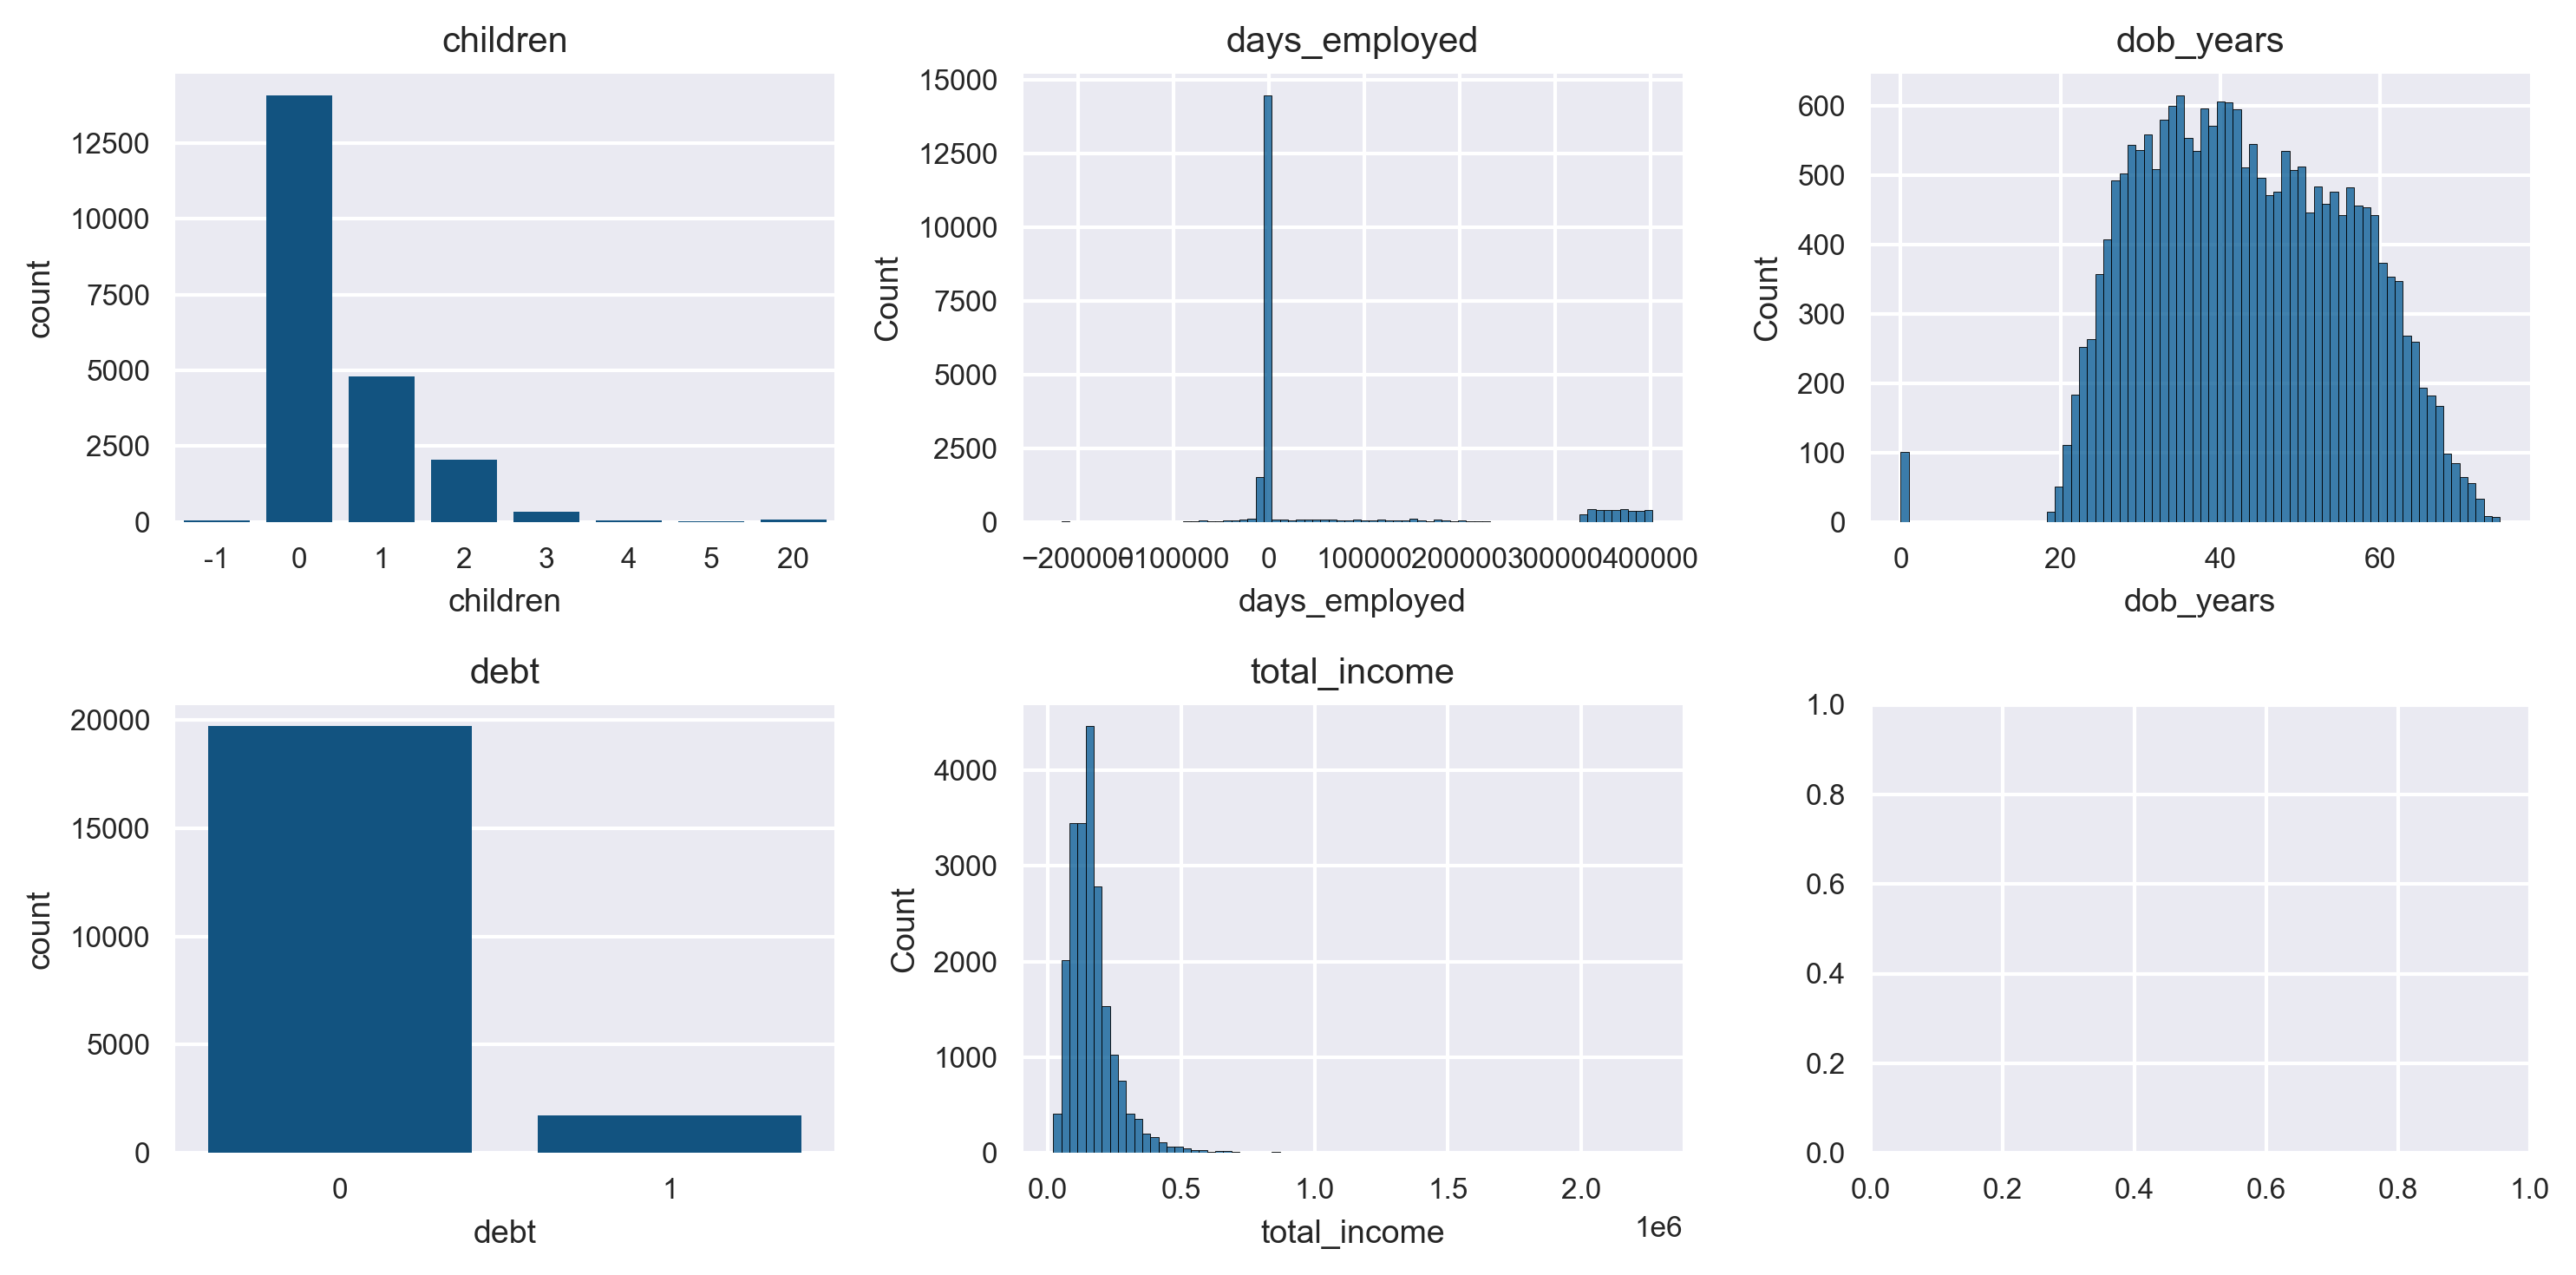

In [27]:
num_columns = bank.select_dtypes(['int', 'float']).columns

fig, axs = plt.subplots(2, 3)
fig.set_size_inches(10, 2 * 2.5) 
fig.set_dpi(300)

new_axs = [item for sublist in axs for item in sublist]

for i, column in enumerate(num_columns):
    if bank[column].nunique() < 20: 
        sns.countplot(data=bank, x=column, ax=new_axs[i], color='#005792')
    else:
        sns.histplot(data=bank, x=column, ax=new_axs[i], color='#005792', bins=74)
    new_axs[i].set_title(column)
    
plt.tight_layout()

___

In [28]:
bank.loc[:, 'children'] = bank['children'].replace({-1: 1, 5: 4, 20: 4})

In [29]:
bank['children'].value_counts()

0    14091
1     4855
2     2052
3      330
4      126
Name: children, dtype: int64

In [30]:
bank['is_employed'] = (bank['days_employed'] > 0).astype(int)

In [31]:
bank.loc[:, 'dob_years'] = bank['dob_years'].replace({0: bank['dob_years'].median()})

___

#### days employed

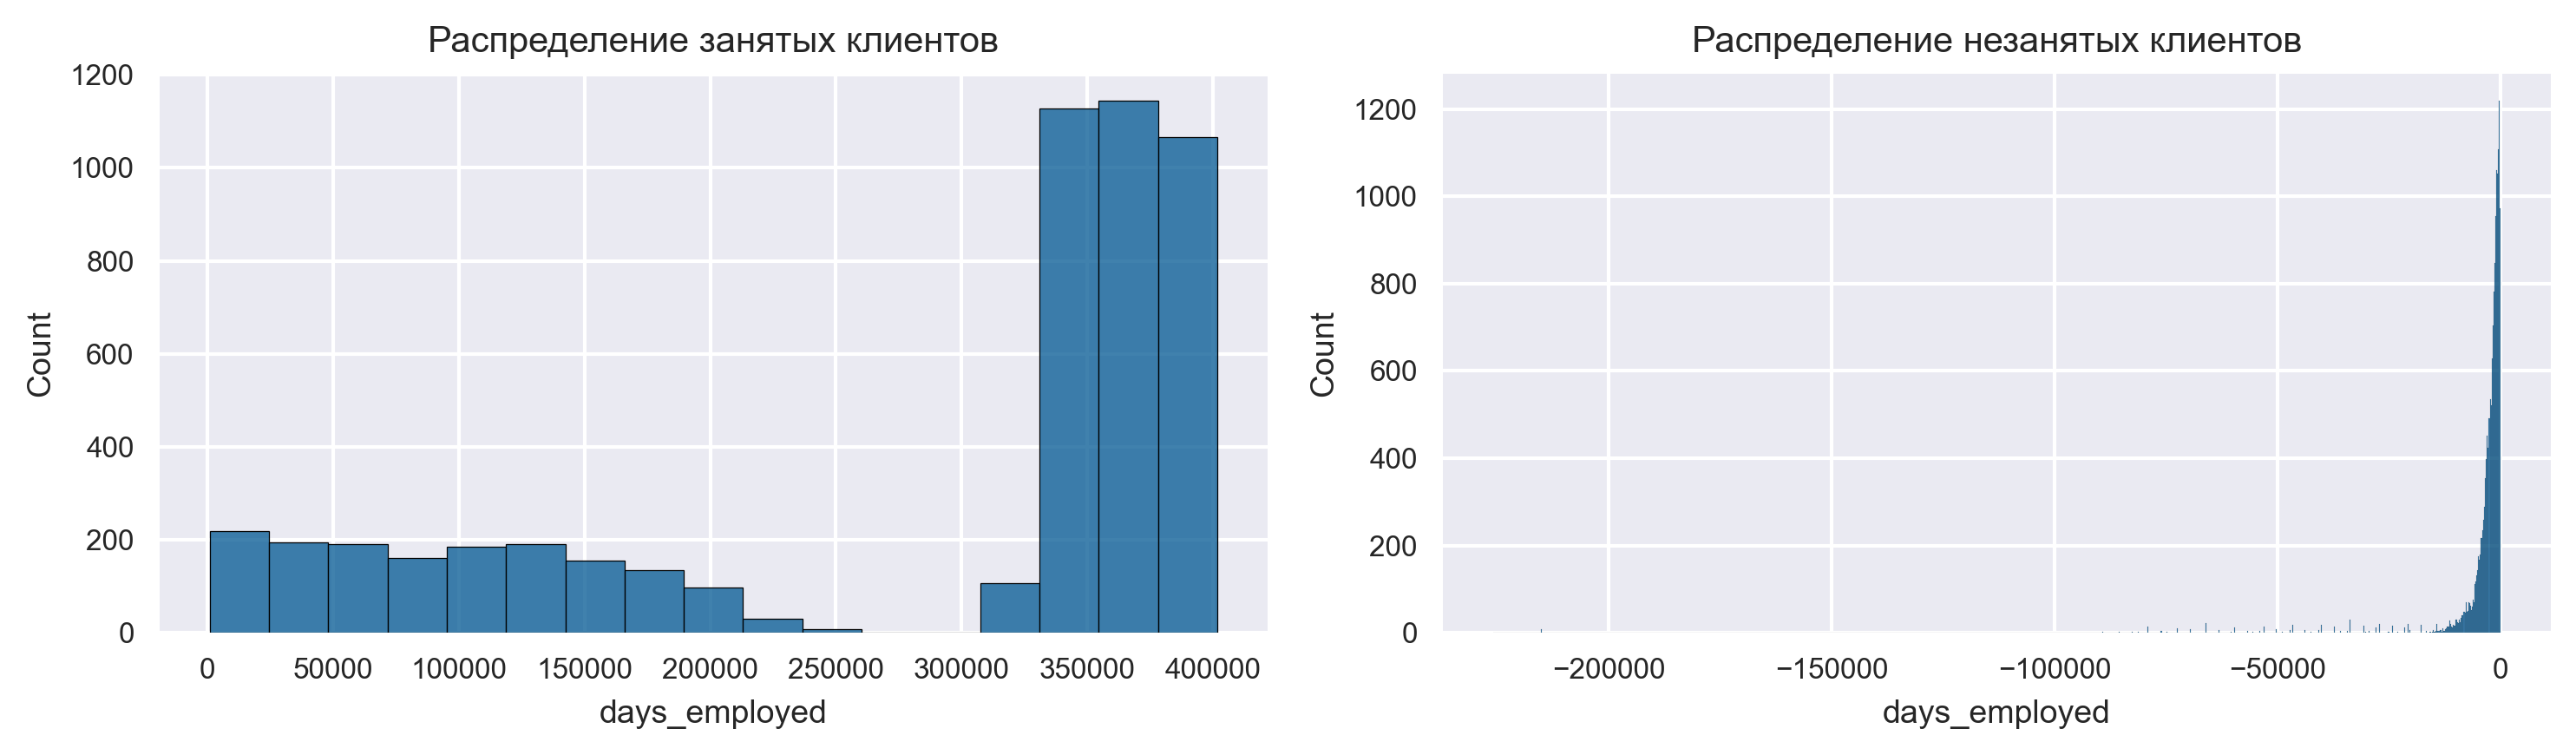

In [32]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10, 3) 
fig.set_dpi(300)

sns.histplot(data=bank[bank['days_employed'] > 0], x='days_employed', color='#005792', ax=axs[0])
sns.histplot(data=bank[bank['days_employed'] < 0], x='days_employed', color='#005792', ax=axs[1])

axs[0].set_title('Распределение занятых клиентов')
axs[1].set_title('Распределение незанятых клиентов')
plt.tight_layout()
plt.show()

____

In [33]:
obj_columns = bank.select_dtypes('object').columns

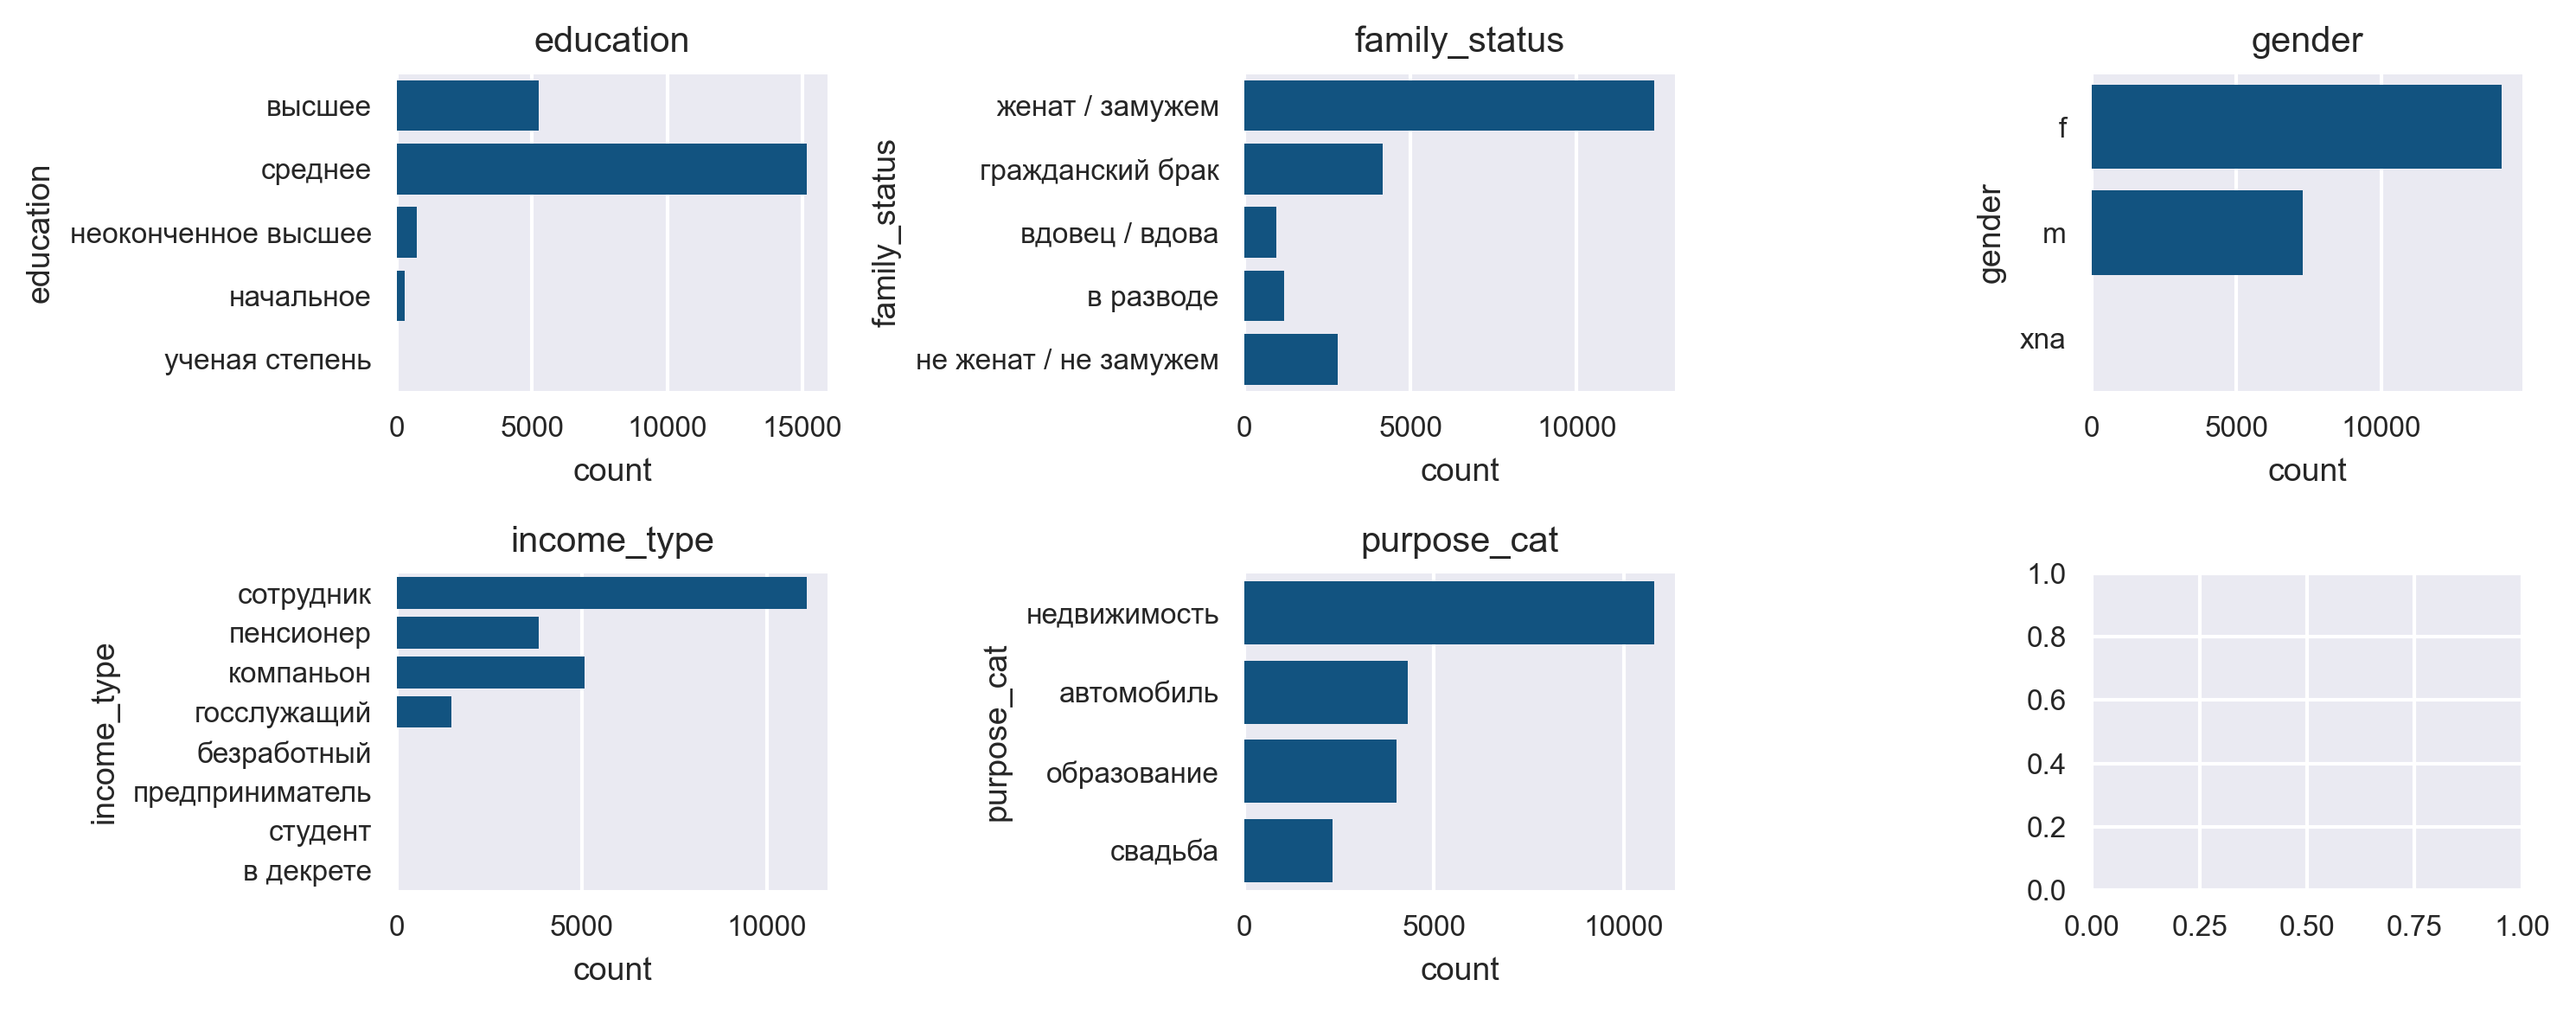

In [34]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(10, 2 * 2) 
fig.set_dpi(300)

new_axs = [item for sublist in axs for item in sublist]

for i, column in enumerate(obj_columns):
    sns.countplot(data=bank, y=column, ax=new_axs[i], color='#005792')
    new_axs[i].set_title(column)
    
plt.tight_layout()

___

In [35]:
bank['gender'].value_counts()

f      14174
m       7279
xna        1
Name: gender, dtype: int64

In [36]:
bank = bank[bank['gender'] != 'xna']

___

In [37]:
bank['income_type'].value_counts()

сотрудник          11084
компаньон           5077
пенсионер           3829
госслужащий         1457
безработный            2
предприниматель        2
в декрете              1
студент                1
Name: income_type, dtype: int64

In [38]:
bank.loc[:, 'income_type'] = bank['income_type'].replace({'предприниматель': 'другое',
                                                          'безработный': 'другое',
                                                          'в декрете': 'другое',
                                                          'студент': 'другое',
                                                         })

___

#### Проверка преобразований

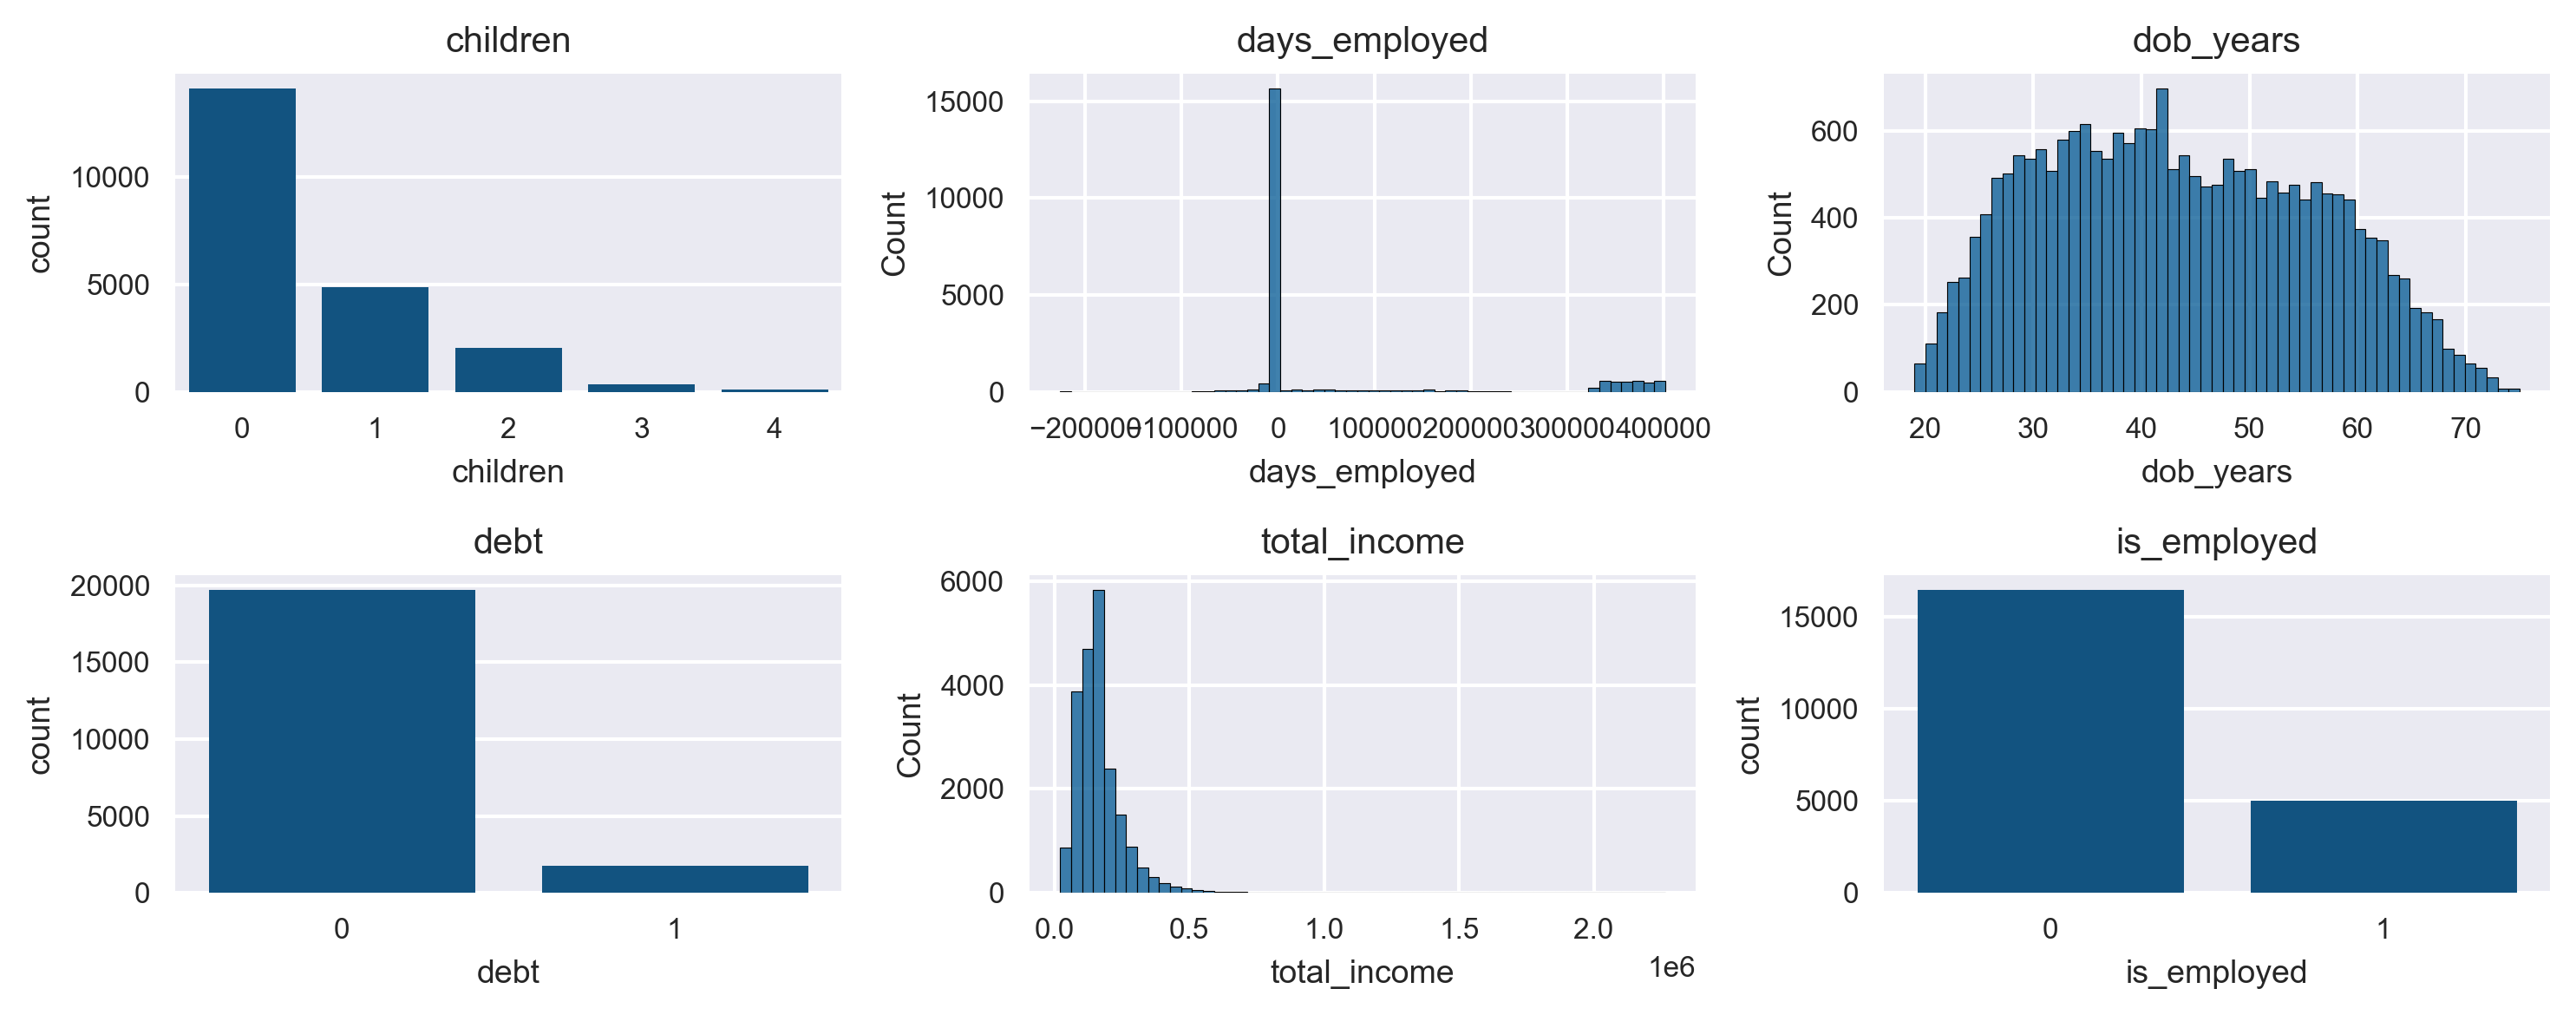

In [39]:
num_columns = bank.select_dtypes(['int', 'float']).columns

fig, axs = plt.subplots(2, 3)
fig.set_size_inches(10, 2 * 2) 
fig.set_dpi(300)

new_axs = [item for sublist in axs for item in sublist]

for i, column in enumerate(num_columns):
    if bank[column].nunique() < 20: 
        sns.countplot(data=bank, x=column, ax=new_axs[i], color='#005792')
    else:
        sns.histplot(data=bank, x=column, ax=new_axs[i], color='#005792', bins=55)
    new_axs[i].set_title(column)
    
plt.tight_layout()

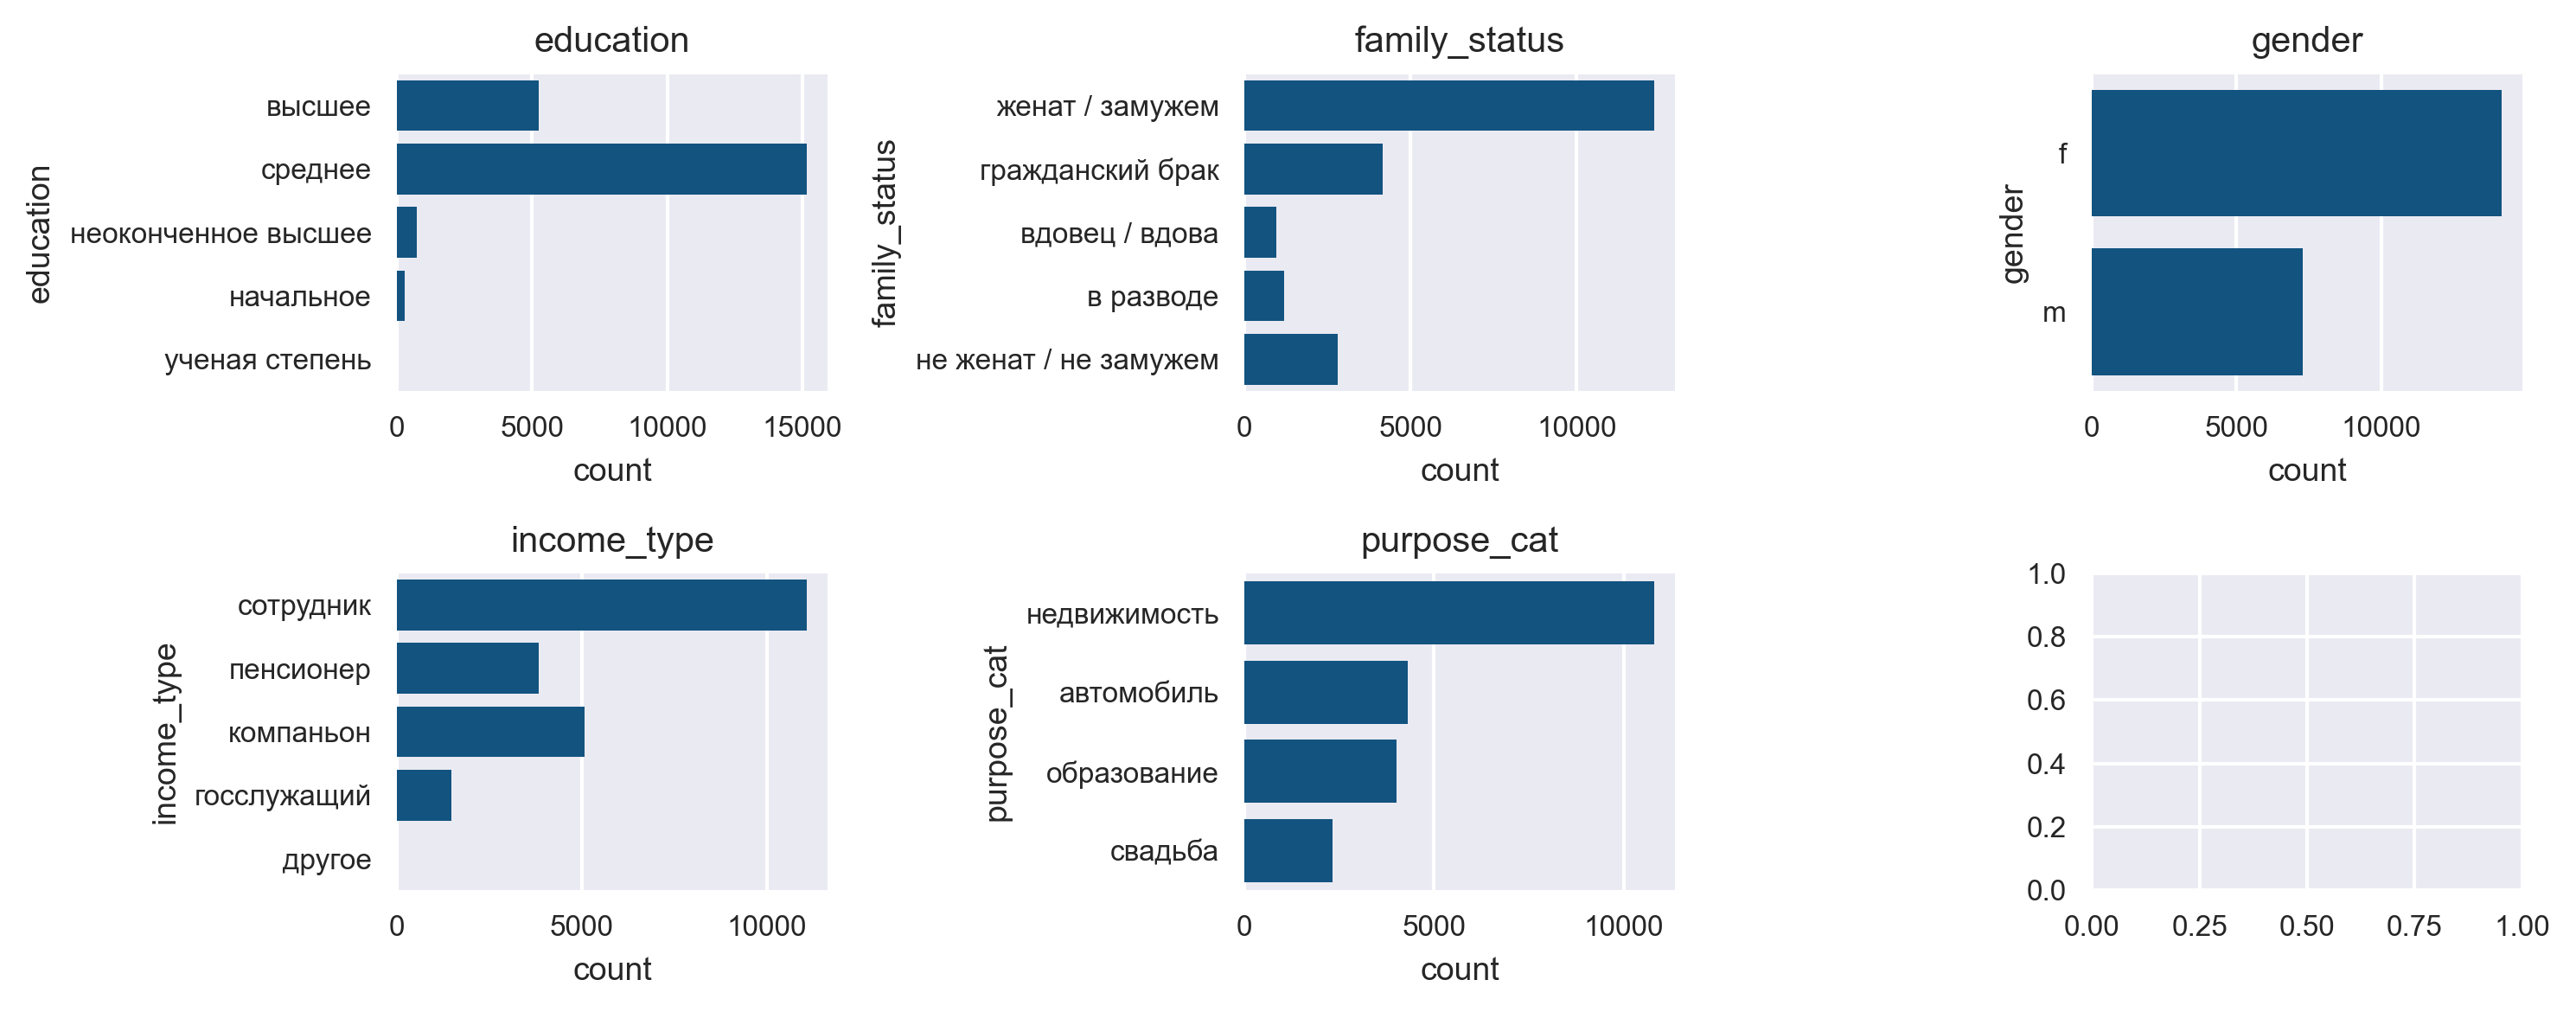

In [40]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(10, 2 * 2) 
fig.set_dpi(300)

new_axs = [item for sublist in axs for item in sublist]

for i, column in enumerate(obj_columns):
    sns.countplot(data=bank, y=column, ax=new_axs[i], color='#005792')
    new_axs[i].set_title(column)
    
plt.tight_layout()

### Шаг 3. Ответьте на вопросы
<a id="step_3"></a>
[Содержание](#content)

1. Есть ли зависимость между наличием детей и возвратом кредита в срок?
2. Есть ли зависимость между семейным положением и возвратом кредита в срок?
3. Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
4. Как разные цели кредита влияют на его возврат в срок?

interval columns not set, guessing: ['children', 'days_employed', 'dob_years', 'debt', 'total_income', 'is_employed']


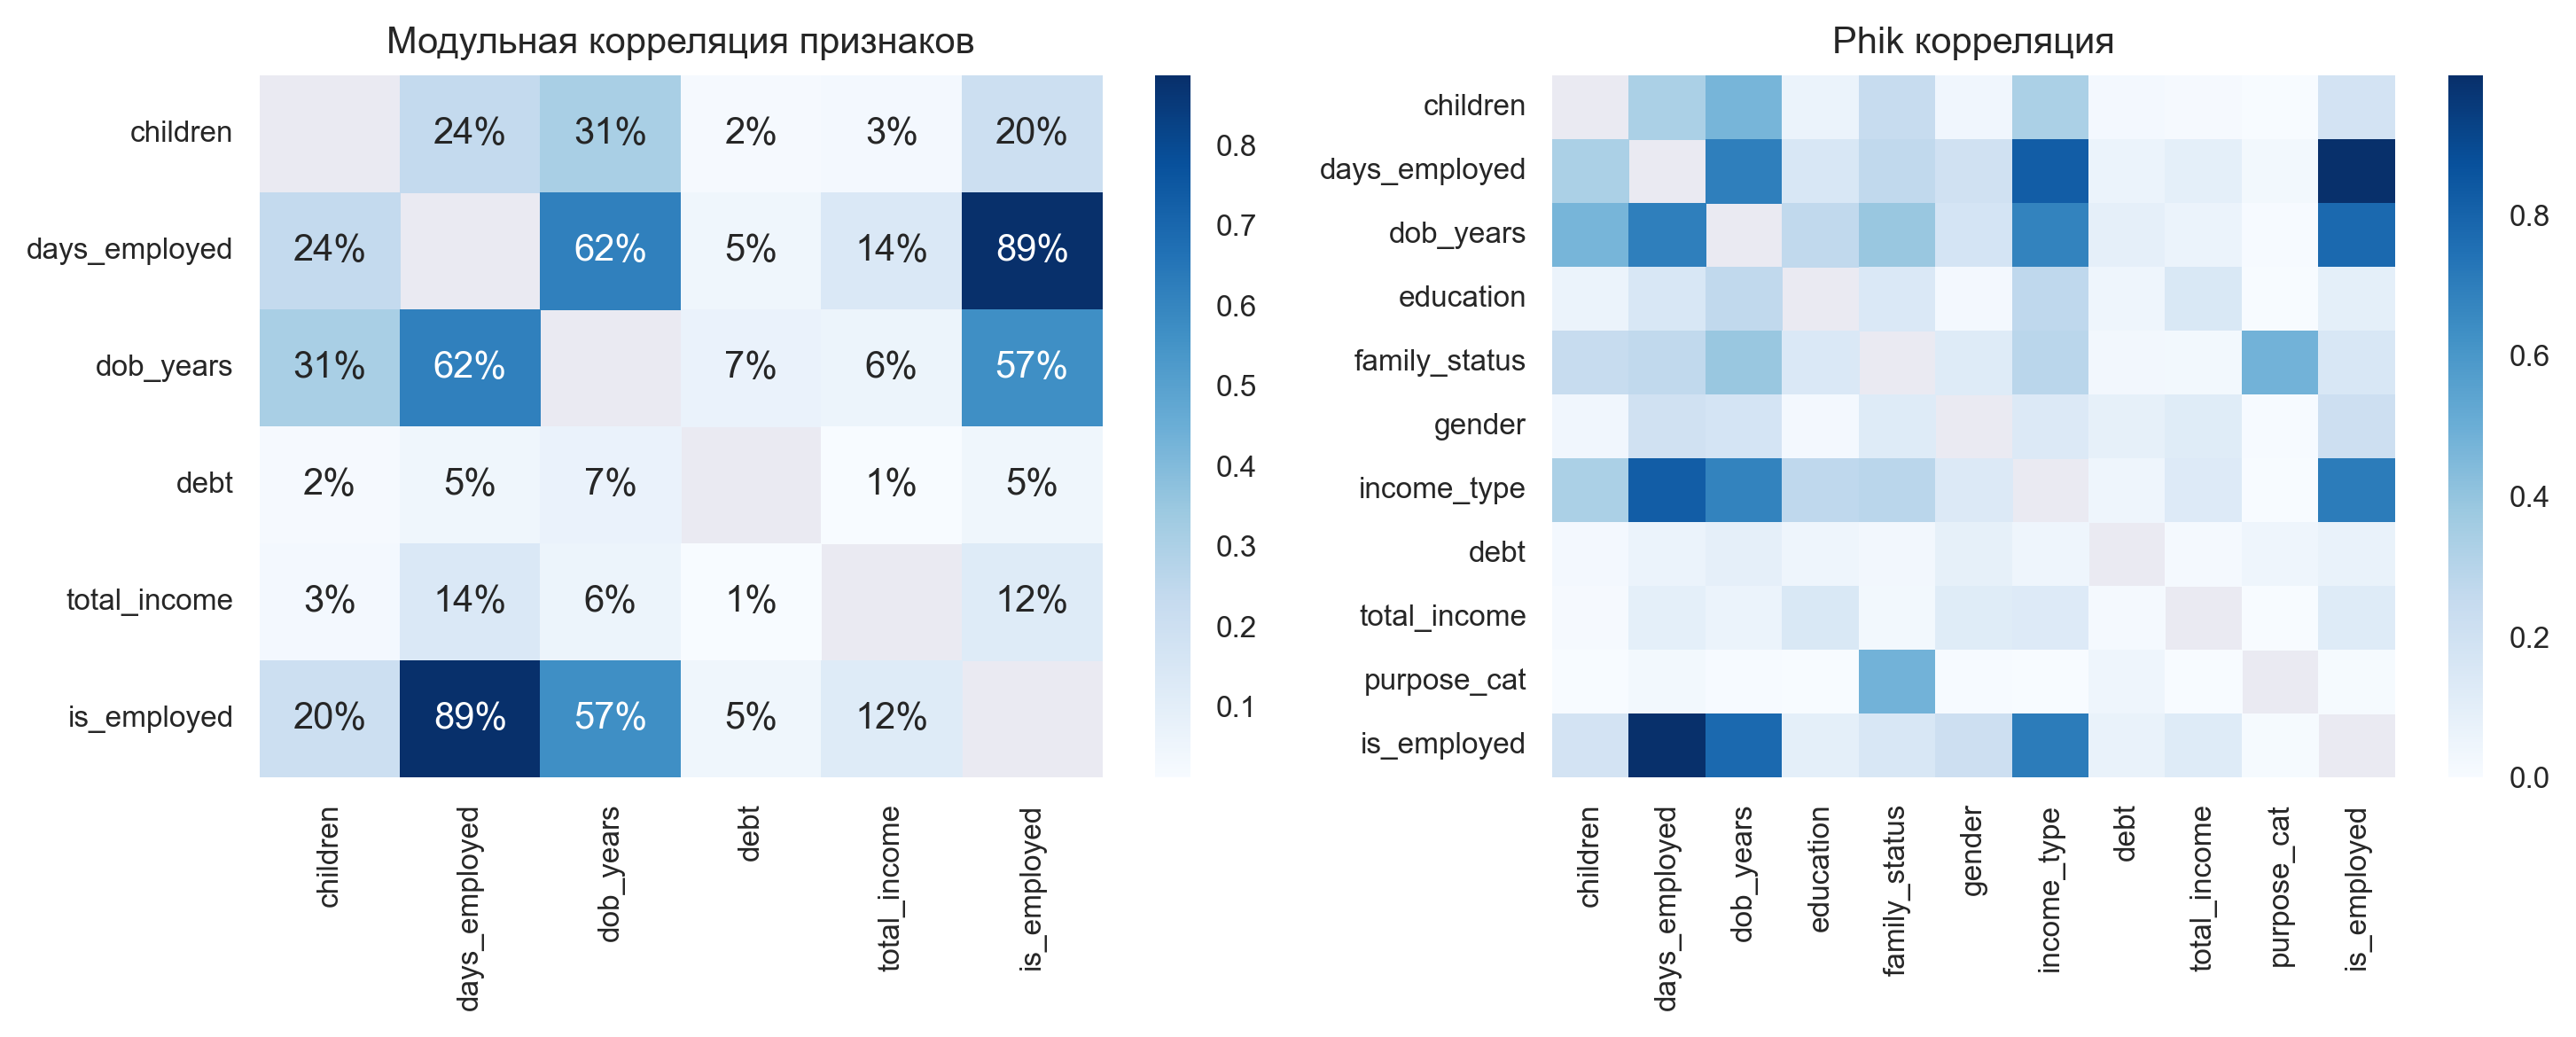

In [41]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10, 2 * 2) 
fig.set_dpi(300)

sns.heatmap(bank.corr().replace({1.0: np.nan}).abs(), ax=axs[0], annot=True, fmt='.0%', cmap='Blues')
sns.heatmap(bank.phik_matrix().replace({1.0: np.nan}), ax=axs[1], cmap='Blues')

axs[0].set_title('Модульная корреляция признаков')
axs[1].set_title('Phik корреляция')

plt.tight_layout()
plt.show()

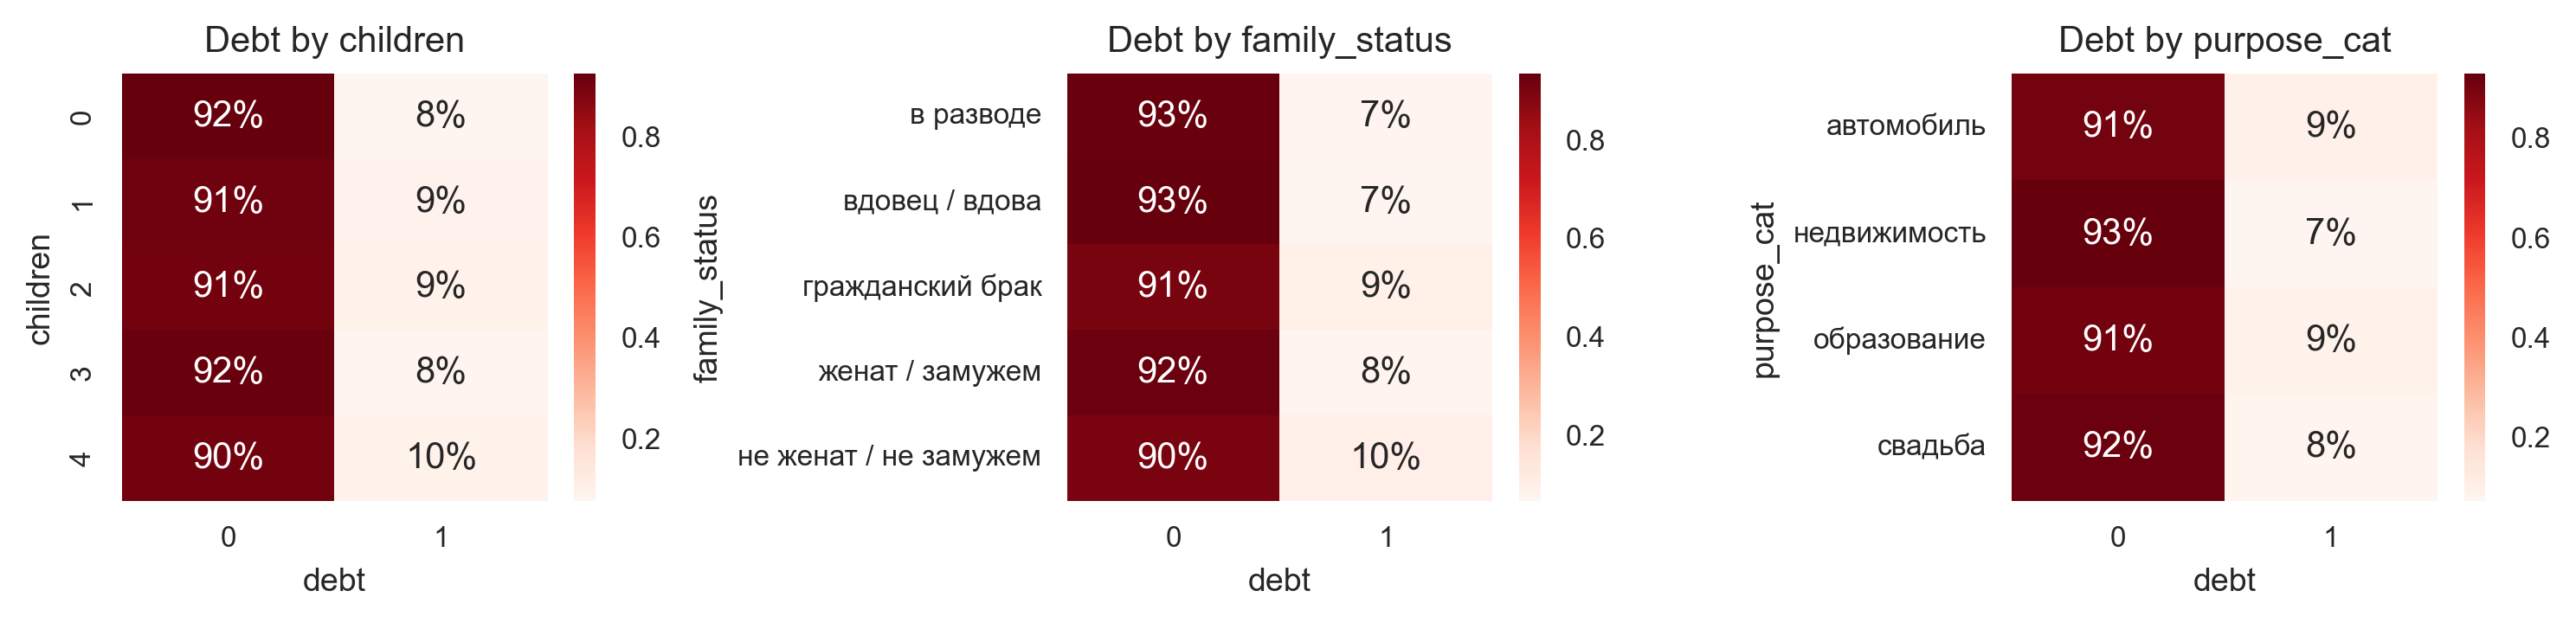

In [42]:
corr_list=['children', 'family_status', 'purpose_cat']

fig, axs = plt.subplots(1, 3)
fig.set_size_inches(10, 1 * 2.5) 
fig.set_dpi(300)

for i, factor in enumerate(corr_list):
    feature_interactions(bank, factor, 'debt', 'gender', my_ax=axs[i])
    axs[i].set_title('Debt by {}'.format(factor))

plt.tight_layout()
plt.show()

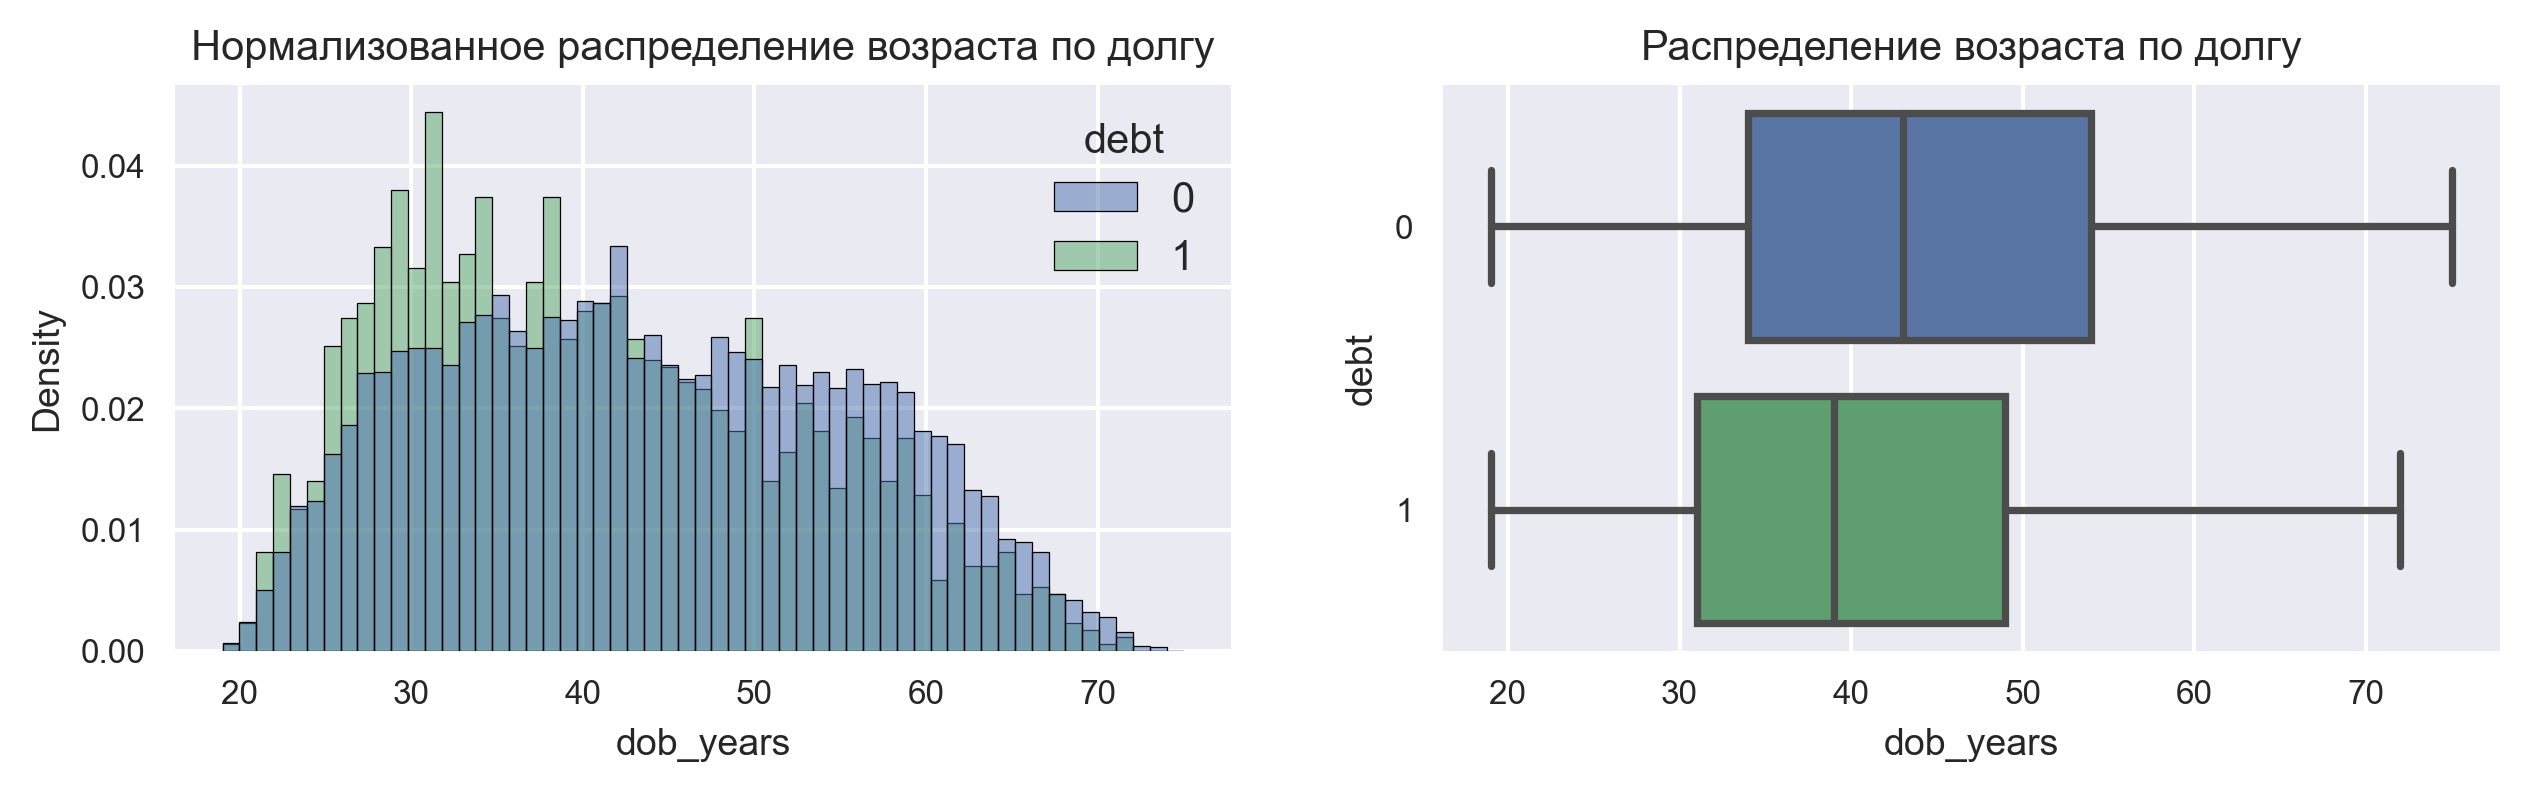

In [43]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10, 2.5) 
fig.set_dpi(300)

sns.histplot(data=bank, x='dob_years', stat='density', common_norm=False,
             ax=axs[0], bins=57, hue='debt')
sns.boxplot(data=bank, y='debt', x='dob_years')

axs[0].set_title('Нормализованное распределение возраста по долгу')
axs[1].set_title('Распределение возраста по долгу')
plt.show()